# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [2]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2019,1,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,10,0,0,0)},
            'retweeted_id': None
            })
        ))

In [3]:
%%time

import json
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
    
filepath = '/home/lisa/Darmstadt/Master Arbeit/05_Data/Scrapy/Twitter_user/Twitter_user/spiders/'
parteien = ['Union', 'SPD', 'Gruene', 'Linke', 'FDP', 'AFD']
parteien_list= {}

users = time_sample_df.user_screen_name

for partei in parteien:
    with open(filepath + partei + '_twitter_Names.json', newline='\n') as json_file:
        Screennames = json.load(json_file)
        parteien_list[str(partei)] = Screennames
        

#for name in set(user_df.screen_name):  #set statt list, wir brauchen jeden User nur einmal
for user in set(users):
    for partei in parteien_list:
        if user in parteien_list[partei]:
            for i in time_sample_df[time_sample_df.user_screen_name == user].index:
                time_sample_df.loc[i, 'Partei'] = partei

#         else:
#             emo_df.at[word, emo] = 0

time_sample_df.head(2)

CPU times: user 13min 25s, sys: 129 ms, total: 13min 25s
Wall time: 13min 25s


_id                      created_at  \
0  5e954cff7973ce357347fb09  Sun Feb 24 17:04:05 +0000 2019   
1  5e954cff7973ce357347fb0b  Fri Feb 22 15:57:45 +0000 2019   

                    id                                           full_text  \
0  1099716608006725632  Wir werden Deutschland bald übernehmen \n#afdwirkt   
1  1098975135892193280  Was ist das ? https://t.co/feRT3o6Ix2                

   is_quote_status  retweet_count lang created_at_datetime  \
0  False            0              de  2019-02-24 17:04:05   
1  True             2              de  2019-02-22 15:57:45   

               user_id   user_name user_screen_name user_location  \
0  1098889251515703296  BystronAFD  AfdBystron                      
1  1098889251515703296  BystronAFD  AfdBystron                      

  user_description  user_followers_count  user_friends_count  \
0  Satire Account   9                     41                   
1  Satire Account   9                     41                   

                  user_created_at Partei  
0  Fri Feb 22 10:16:28 +0000 2019  NaN    
1  Fri Feb 22 10:16:28 +0000 2019  NaN

In [26]:
%%html
<style>
table {float:left}
</style>

## Übersicht der Tweets pro Partei 

Gibt es Namen die keiner Partei zugeordnet werden konnten?
* AfdBystron - Satire Account
* EspendillerM - Name geändert wegen Dr. Titel

*Müssen bei nächstem Datenbank- Update angepasst werden*


##### Beispiel für die Übersicht für Tweets im Zeitraum 01.01.2019 - 10.05.2020

|Partei  |  Tweets |      |mdp gesamt|mdp Twitter|Anteil Twitter user|Tweets pro user
|--------|---------|      |----------|-----------|----------|---------------
|AFD     |  12959  |      |89        |26         |29,21     |498
|FDP     |  47759  |      |80        |69         |86,25     |692
|Gruene  |  39910  |      |67        |57         |85,07     |700
|Linke   |  36422  |      |69        |49         |71,01     |743
|SPD     |  44520  |      |152       |102        |67,11     |436
|Union   |  39979  |      |246       |122        |49,59     |328


##### Entferne Tweets ohne Parteizuordnung

In [130]:
# no_party = time_sample_df[time_sample_df.Partei.isnull()].user_screen_name
# for i in set(no_party):
#     print(i)

sample_df = time_sample_df[time_sample_df.Partei.isnull()== False]
len(sample_df['user_screen_name'])

221549

#### Unterteilung in Bins und erstellen eines Dictionarys für Zeiträume

In [144]:
# Sortieren nach Datum/Zeit
sample_df = sample_df.sort_values(by = ['created_at_datetime'])

# Zerschneiden in Bins
sample_df['bins'] = pd.cut(sample_df['created_at_datetime'], bins=70, labels=list(range(1,71)))

labels=list(range(1,71))
weeks = {}
    
for i in labels:
    weeks['week_'+str(i)] = sample_df[sample_df['bins'] == i]    

bin_sum_per_week = {}

for label in range(1,71): 
    df = sample_df[sample_df['bins'] == label]
    head = list(df.created_at_datetime.head(1))[0]
    tail = list(df.created_at_datetime.tail(1))[0]
    bin_sum_per_week[label] = {}
    bin_sum_per_week[label]['Von'] = head
    bin_sum_per_week[label]['Bis'] = tail
bin_sum_per_week


{1: {'Von': Timestamp('2019-01-01 00:01:32'),
  'Bis': Timestamp('2019-01-08 00:58:50')},
 2: {'Von': Timestamp('2019-01-08 03:54:12'),
  'Bis': Timestamp('2019-01-15 00:49:42')},
 3: {'Von': Timestamp('2019-01-15 04:09:04'),
  'Bis': Timestamp('2019-01-21 23:26:58')},
 4: {'Von': Timestamp('2019-01-22 05:37:35'),
  'Bis': Timestamp('2019-01-29 06:52:01')},
 5: {'Von': Timestamp('2019-01-29 06:55:44'),
  'Bis': Timestamp('2019-02-05 08:33:28')},
 6: {'Von': Timestamp('2019-02-05 08:38:12'),
  'Bis': Timestamp('2019-02-12 10:17:02')},
 7: {'Von': Timestamp('2019-02-12 10:21:02'),
  'Bis': Timestamp('2019-02-19 11:58:40')},
 8: {'Von': Timestamp('2019-02-19 12:01:07'),
  'Bis': Timestamp('2019-02-26 13:43:25')},
 9: {'Von': Timestamp('2019-02-26 13:45:18'),
  'Bis': Timestamp('2019-03-05 15:25:55')},
 10: {'Von': Timestamp('2019-03-05 15:42:54'),
  'Bis': Timestamp('2019-03-12 17:02:29')},
 11: {'Von': Timestamp('2019-03-12 17:10:09'),
  'Bis': Timestamp('2019-03-19 18:31:10')},
 12: {'V

#### Erstellen eines Dictionary für Parteizugehörikgeit

In [139]:
partei_dic = {}

for partei in parteien:
    partei_dic['tweets_'+ partei] = sample_df[sample_df['Partei'] == partei]  

# EDA

In [14]:
mdp_tweets = sample_df[['created_at_datetime','user_screen_name','Partei', 'full_text']]
mdp_tweets.head()

created_at_datetime user_screen_name Partei  \
23 2020-04-13 09:32:45  StBrandner       AFD     
24 2020-04-13 09:15:36  StBrandner       AFD     
25 2020-04-13 08:14:19  StBrandner       AFD     
26 2020-04-11 13:17:14  StBrandner       AFD     
27 2020-04-11 06:08:15  StBrandner       AFD     

                                                                                                                                                                                                                                                                                                full_text  
23  Ganz einfach:\nWeil es (zumal auf Dauer!) niemals ein „datenschutzgerechtes Tool“ geben und das ein weiterer großer Schritt Richtung Überwachungsstaat sein wird!\nIch wünsche mir dringend etwas mehr Problembewusstsein und kritische Distanz beim Datenschutzbeauftragten! https://t.co/Rx0cAhIc97  
24  @zeitonline_pol Fordern wir schon lange! Endlich bewegen sich auch die #Altparteien! #AfDwirkt! https://t.co/OjUFW0TeIf                                                                                                                                                                                
25  Nicht mehr ganz so neu... aber nach wie vor sehr gut lesbar! HIER RUNTERLADEN:\nhttps://t.co/JSG40sIJl3\n#AfD #Berlin #Bundestag #Brandner https://t.co/u1OALE265O                                                                                                                                     
26  „20 Männer attackieren Frankfurter Corona-Polizeistreife“ https://t.co/jAbADAYGDA                                                                                                                                                                                                                      
27  Parkautomat in #Erfurt...🤔 https://t.co/HDHLJM4xBA

##### Betrachtung auf Tagesebene

In [15]:
date = []
for timestamp in mdp_tweets.created_at_datetime:
    date.append(timestamp.date())
    
mdp_tweets['date'] = date


/usr/local/anaconda3/bin/ipython:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### Pivotierung
* Wie viel hat welche Partei an welchem Tag getwittert?
* Wie viel haben die Mitglieder einer Partei in best. Zeiraum getwittert?
* Wie viel hat ein best Mitglied an welchem Tag getwittert?

In [75]:
mdp_partei = mdp_tweets[['Partei', 'date', 'user_screen_name', 'full_text']]
partei_piv = pd.pivot_table(mdp_partei, columns = 'Partei', index = 'date', aggfunc = np.count_nonzero )
partei_piv['user_screen_name']

Partei      AFD  FDP  Gruene  Linke  SPD  Union
date                                           
2019-01-01  17   21   42      18     36   26   
2019-01-02  8    39   33      40     22   19   
2019-01-03  11   55   44      24     41   39   
2019-01-04  14   51   30      41     54   42   
2019-01-05  8    42   41      18     34   33   
...         ..   ..   ..      ..     ..   ..   
2020-05-05  48   156  119     94     123  139  
2020-05-06  34   234  138     105    120  157  
2020-05-07  33   164  125     112    120  147  
2020-05-08  26   62   88      106    125  99   
2020-05-09  34   88   57      77     103  42   

[495 rows x 6 columns]

In [18]:
name_piv_dic = {}
    
for partei in parteien:
    partei_mdp = mdp_tweets[mdp_tweets['Partei'] == partei]
    partei_names = partei_mdp[['user_screen_name', 'date']]
    for name in set(partei_names['user_screen_name']):
        name_piv = pd.pivot_table(partei_names[partei_names['user_screen_name'] == name], index = 'date', aggfunc = np.count_nonzero)
        name_piv_dic[name] = name_piv
        
#name_piv_dic['StBrandner'].tail(50)

In [19]:
partei_piv_dic = {}

for partei in parteien:
    partei_mdp = mdp_tweets[mdp_tweets['Partei'] == partei]
    patei_names = partei_mdp[['user_screen_name', 'date']]
    partei_piv = pd.pivot_table(patei_names, index = 'user_screen_name', aggfunc = np.count_nonzero )
    partei_piv_dic[partei] = partei_piv
    
#partei_piv_dic['Gruene']

Partei
AFD       12959
FDP       47759
Gruene    39910
Linke     36422
SPD       44520
Union     39979
Name: full_text, dtype: int64

In [ ]:
mdp_gesamt = [246, 152, 67, 69, 80, 89] # https://www.bundestag.de/parlament/plenum/sitzverteilung_19wp

tweets_piv = pd.pivot_table(mdp_partei, index = 'Partei', aggfunc = np.count_nonzero )['full_text']
Tweets = []
for partei in parteien:
    Tweets.append(tweets_piv[partei])

mdp_Twitter = []
for partei in parteien:
    mdp_Twitter.append(len(partei_piv_dic[partei]))

summary_df = pd.DataFrame({'Partei':parteien, 'Tweets': Tweets, 'mdp_gesamt': mdp_gesamt, 'mdp_Twitter': mdp_Twitter})
summary_df['Anteil_Twitter_user'] = round(summary_df['mdp_Twitter']/summary_df['mdp_gesamt']*100, 2)
summary_df['Tweets_pro_user'] = round(summary_df['Tweets']/summary_df['mdp_Twitter'])
summary_df.index = summary_df['Partei']
summary_df = summary_df.drop(columns = 'Partei')
summary_df


In [338]:
#mdp_partei[mdp_partei['date'] == datetime.date(2020,5,7)]
time_sample_df.loc[21983]
# for date in mdp_partei['date']:
#     print(date)

_id                     5e95920f36c17d9b398f3bcf                                                                                                                                  
created_at              Tue Apr 14 08:22:15 +0000 2020                                                                                                                            
created_at_datetime     2020-04-14 08:22:15                                                                                                                                       
full_text               @jorg_radek fröhlicher gruss aus der sonnigen freien und hansestadt jörg 👌🏻                                                                               
id                      1249976249268797447                                                                                                                                       
is_quote_status         False                                                                            

In [346]:
#name_piv_dic['StBrandner'][name_piv_dic['StBrandner'].index == datetime.date(2020,2,6)]
for tweet in mdp_partei.index:
    if((mdp_partei['user_screen_name'][tweet] == 'StBrandner') and mdp_partei['date'][tweet] == datetime.date(2020,5,3)):
        #print(mdp_partei['date'][tweet])
        print(mdp_partei['full_text'][tweet])


+++5 Fragen und 5 Antworten ==&gt; #Deutschland im Sinkflug, Arbeitslosenzahlen steigen, 10 Mio. #Bürger in #Kurzarbeit, Krise schlimmer als befüchtet! Der #Wahnsinn muss JETZT enden!+++
https://t.co/9RRNaoKbMA
#AfD #5Fragen5Antworten #5f5a #nurnochAfD #Berlin #Bundestag #Brandner https://t.co/8Ga0uwIjCg
Waren die denn weg? Schade, hab‘ ich gar nicht bemerkt... https://t.co/8tFQF8z87S
#Gera: #Extrawurst für #OB? https://t.co/IQ7qYR8Wfs
Moin! Tag der #Pressefreiheit!
Weiß man Neues zu den Tätern hinsichtlich des Angriffs auf die #heuteshow, zum #Kahrs-Examensbetrug usw.? Oder feiert sich die #Presse lieber selbst und kommt gar nicht zum Arbeiten?😉
Weiß man endlich Neues zu den Täter*innen und deren Motivation? https://t.co/uB8h3gKKpw
Ein klares NEIN zu #Corona-Spitzel-App, #Immunitätsausweis, #Zwangsimpfungen und weiteren #Drangsalierungen, #Schikanierungen &amp; #Eingriffe|n!#Freiheit! #Demokratie! #Grundrechte!
https://t.co/a2XFYvheUr
#AfD #nurnochAfD #Berlin #Bundestag #Brandner
Sati

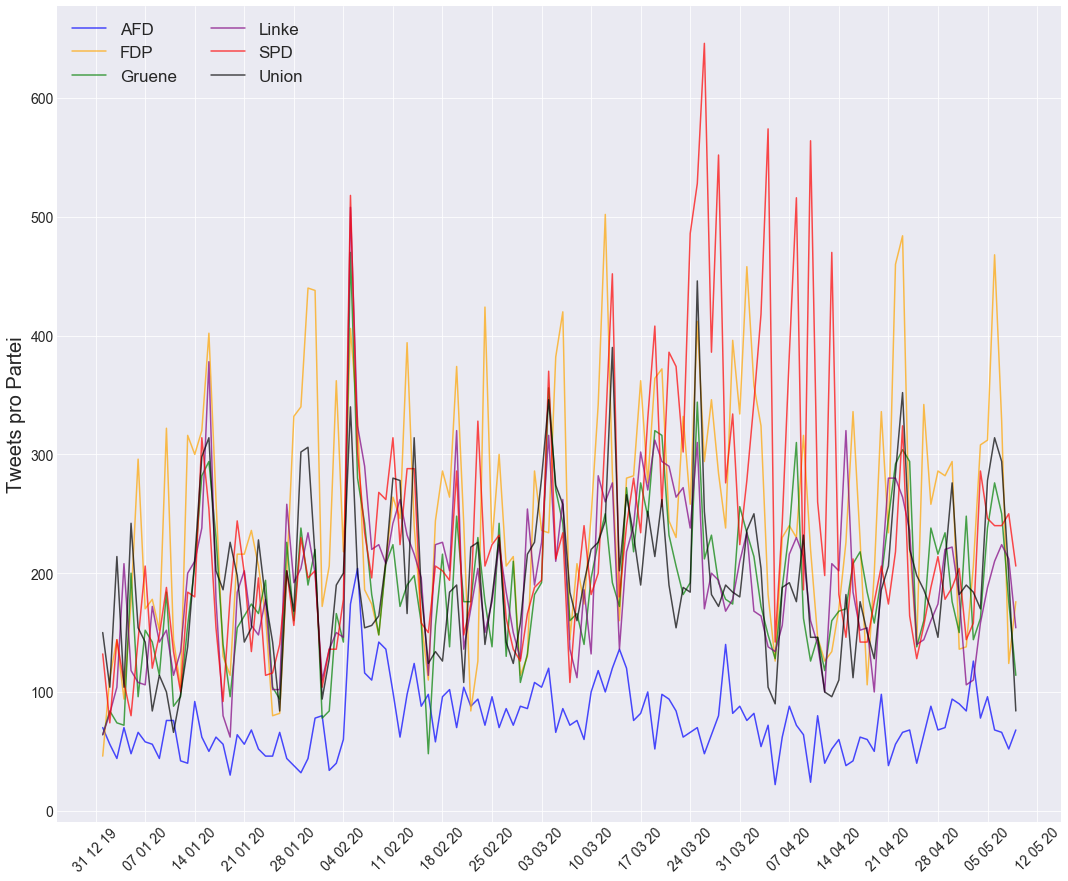

In [145]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (18, 15))
ax = fig.add_subplot(111)

num=0
for column in partei_piv:
    ax.plot(partei_piv.index, partei_piv[column], color = my_palette[num], alpha=0.7, label = column)
    num+=1
    
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
# = ax.set_xlabel('Datum', size = 20)
plt.legend(loc = 2, ncol = 2, fontsize = 17)

# y_tags
ytag = ax.set_yticklabels(np.arange(partei_piv.values.min()-122, partei_piv.values.max()+50, 100), fontsize = 14)

# x_tags
xtag = ax.set_xticklabels(partei_piv.index, rotation = 45, fontsize = 14)

months = mdates.MonthLocator()
weeks = mdates.WeekdayLocator()
months_fmt = mdates.DateFormatter('%d %m %y')

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(weeks)



In [55]:
len(my_palette)
#len(partei_piv.columns)

6

## Text Cleaning

In [134]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


# Remove punctuation
sample_df['full_text_processed'] = sample_df['full_text'].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('http.*', '', x))

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(200)

31432     ZDFWATCH bikeberlin13 SenUVKBerlin RegineGuenther Konstruktive auch zugespitzte Kritik ist immer willkommen Aber die Kritik sollte halt nicht beim ersten Blick drauf zu Staub zerfallen In dem Sinne frohes neues                                          
114060    Mellcolm LenaRogl froileinmueller Das kann ich nur zurückgeben❣️❣️❣️ So tolle Frauen                                                                                                                                                                        
42819     Happy 2019 🤩🎉🥂                                                                                                                                                                                                                                              
147515    gixcx522 cyb3rrunn3r JDeweller dieLinke Auch wenn die Ganzgenaunehmer jetzt wieder aufheulen Zahl das was du kannst und willst Dabeisein ist alles 😃                                                     

#### Durchsuche nach Tweets und sortiere aus

In [135]:
# Print words that match certain words:
#sample_df['full_text_processed'][sample_df['full_text_processed'].str.match(r'.*brexit.*')==True]

# Remove Tweets that match certain words:
sample_df = sample_df[~sample_df.full_text_processed.str.contains("fröhlicher gruss")]
#time_sample_df.groupby('Partei').size()
#sample_df.groupby('Partei').size()

#### Stopwords

In [136]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'Das', 'the', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde']
for word in mehr_sw:
    stop_words.append(word)
    


# Wordclouds
#### Basic

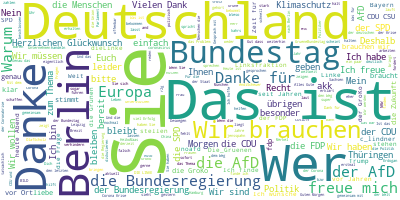

In [137]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(sample_df['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#fig, axs = plt.subplots(1,2)

#df['korisnika'].plot(ax=axs[0])
#df['osiguranika'].plot(ax=axs[1])

#### Wordcloud zu bestimmtem Zeitunkt

(-0.5, 399.5, 199.5, -0.5)

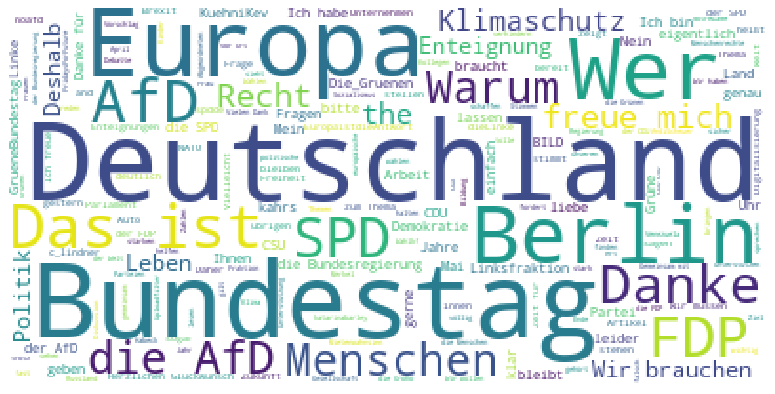

In [117]:
# Import the wordcloud library
from wordcloud import WordCloud

sample_df_date = sample_df[sample_df.created_at_datetime >= datetime.datetime(2020,5,8,0,0,0)]
sample_df_date = sample_df.loc[(sample_df['created_at_datetime'] <= datetime.datetime(2019,5,8,0,0,0)) & (sample_df['created_at_datetime'] >= datetime.datetime(2019,4,1,0,0,0))]

# Join the different processed titles together.
long_string = ','.join(sample_df_date['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure( figsize=(16,7) )
plt.imshow(wordcloud)
plt.axis("off")



#### Wordcloud Gegenüberstellung

Text(0.5, 1.05, 'SPD_Tweets')

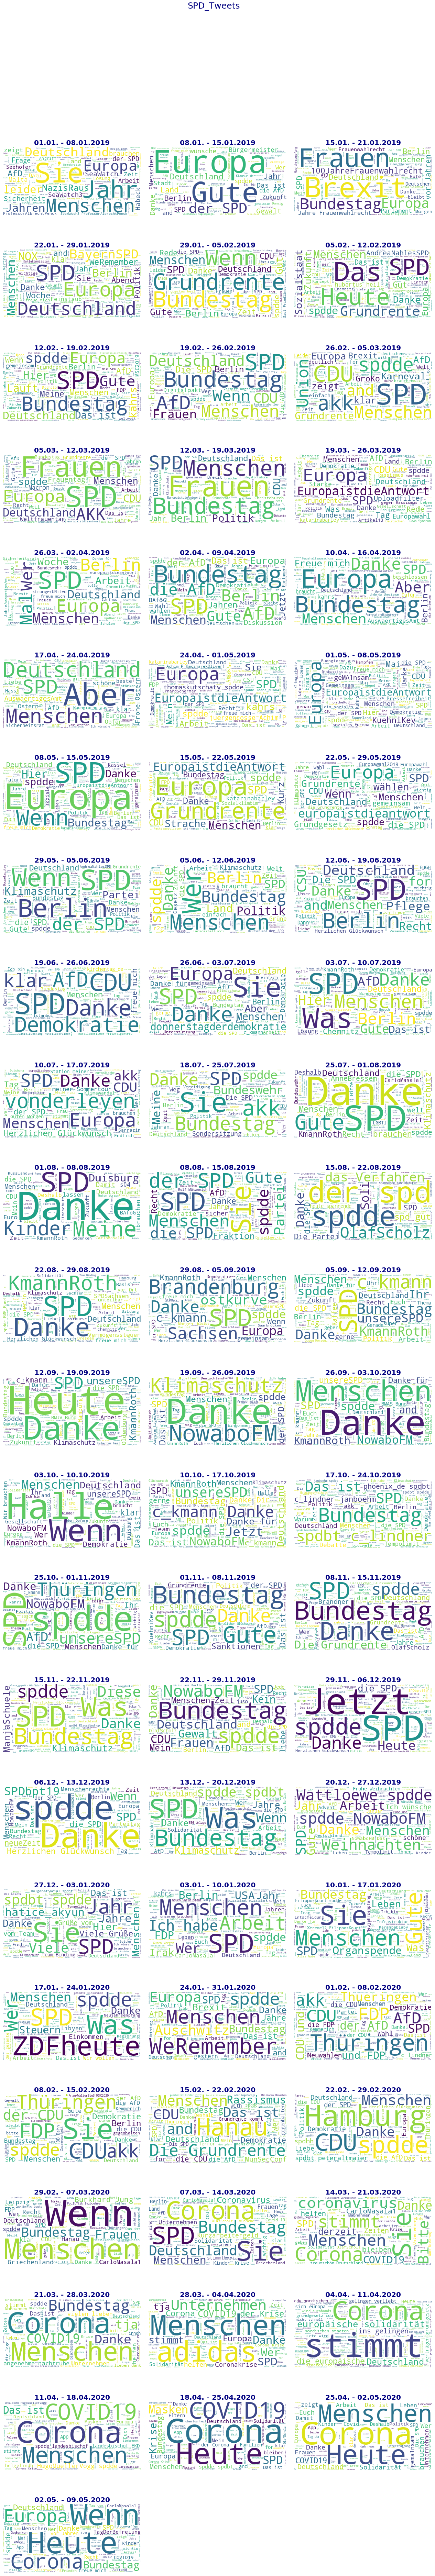

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud

party = 'SPD'

sample_df_partei = sample_df[sample_df.Partei == party]

date_dic_partei = {}
# for partei in parteien:
#     week_dic_partei['tweets_'+ partei] = date_dic_partei[sample_df['Partei'] == partei]  
    
for week in weeks:
    #date_dic_partei[week + '_' + 'AFD'] = weeks[week].loc("Partei" == 'AFD')
    date_dic_partei[week + '_' + party] = weeks[week].loc[weeks[week].Partei == party]
    #print(weeks[week].loc[weeks[week].Partei == "AFD"])



def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (18, 100))

for i, n in zip(date_dic_partei, range(1,71)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
 

    ax = fig.add_subplot(24,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_week=date_dic_partei[i]
    long_string = ','.join(sample_df_week['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')

fig.suptitle(party + '_Tweets', fontsize=25, color='navy', y=1.05)

#### Wordcloud Gegenüberstellung von Parteien

/usr/local/anaconda3/bin/ipython:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5, 1.05, 'Tweets 8. Mai ohne Corona')

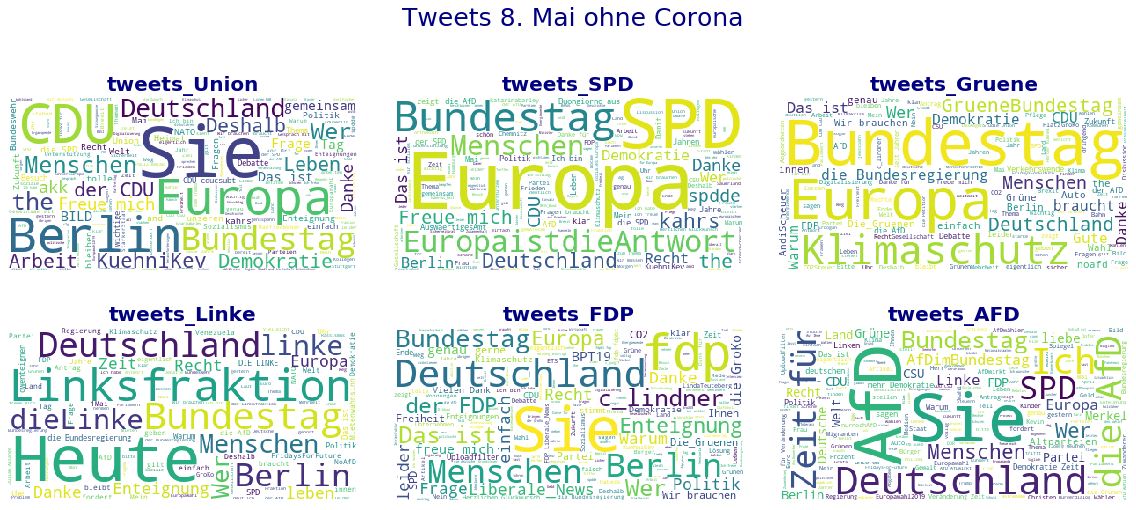

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud


#sample_df_date = sample_df[sample_df.created_at_datetime >= datetime.datetime(2020,5,8,0,0,0)]
sample_df_date = sample_df.loc[(sample_df['created_at_datetime'] <= datetime.datetime(2019,5,8,0,0,0)) & (sample_df['created_at_datetime'] >= datetime.datetime(2019,4,1,0,0,0))]


partei_dic_date = {}
for partei in parteien:
    partei_dic_date['tweets_'+ partei] = sample_df_date[sample_df['Partei'] == partei]  


def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (16, 16))
#fig.subplots_adjust(top=0.8)

for partei, n in zip(partei_dic_date, range(1,7)):
    title = str(partei)
    
    ax = fig.add_subplot(5,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_partei=partei_dic_date[partei]
    long_string = ','.join(sample_df_partei['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
fig.suptitle('Tweets 8. Mai ohne Corona', fontsize=25, color='navy', y=1.05)

# Barplot

#### Barplot Gegenüberstellung

In [ ]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde', 'corona', 'covid19', 'coronakrise', 'coronavirus', 'krise']
for word in mehr_sw:
    stop_words.append(word)
    


In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0] # total_counts = total_counts + t.toarray
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    with plt.xkcd():
        ax = fig.add_subplot(5,3,n, title =  title)
        fig.tight_layout()
        ax = sns.barplot(x_pos, counts, palette="GnBu_d")
        ax.set_xticklabels(words, rotation = 45, fontsize=13)
        return ax

    
# Initialise the count vectorizer with the german stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)


fig = plt.figure(figsize = (16, 22))
for i, n in zip(weeks, range(1,16)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(weeks[i]['full_text_processed'])
    plot_10_most_common_words(count_data, count_vectorizer, title)
    
fig.suptitle('Häufigkeit von Begriffen über alle Parteien hinweg', fontsize=25, color='darkslategray', y=1.05)
plt.show()


# Sentiment Analyse - Wörterbuch
## Simple TextBlob Analysis

In [ ]:
#import nltk
#nltk.download('punkt')
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df.full_text_processed[33504]) 

# print(blob.sentences)
# print(blob.tokens)
# print(blob.tags)
# print(blob.noun_phrases)
print(blob.sentiment)

In [ ]:
# https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
sample_df['Polarity']     = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[0])
sample_df['Subjectivity'] = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[1])
sample_df

In [ ]:
# compute sentiment scores (polarity) and labels
sentiment_scores = sample_df['Polarity']
sentiment_category = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]


# sentiment statistics per news category
df_weeks = pd.DataFrame([list(sample_df['bins']), list(sample_df['Partei']), list(sentiment_scores), list(sentiment_category)]).T
df_weeks.columns = ['bins', 'partei', 'sentiment_score', 'sentiment_category']
df_weeks['sentiment_score'] = df_weeks.sentiment_score.astype('float')
df_weeks.groupby(by=['partei']).describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = []


for i, n in zip(weeks, range(1,16)):
    label = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    labels.append(label)
    
ax = sns.catplot(x="bins", hue="sentiment_category", height=13,
                    data=df_weeks, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
ax.set_xticklabels(labels, rotation = 45, fontsize=12)

#print(labels)

In [ ]:
ax = sns.catplot(x="partei", hue="sentiment_category", height=13,
                    data=df_weeks, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
ax.set_xticklabels(rotation = 45, fontsize=12)

In [ ]:
partei_dic_sent = {}
for partei in parteien:
    partei_dic_sent['sentiment_'+ partei] = df_weeks[df_weeks['partei'] == partei]  
    
for i, n in zip(weeks, range(1,16)):
    label = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    labels.append(label)

fig = plt.figure(figsize = (15, 18))

for partei, n in zip(parteien, range(1,7)):
    ax = fig.add_subplot(3,2,n, title = partei)
    fig.tight_layout()
    sns.catplot(x="bins", hue="sentiment_category", data=partei_dic_sent['sentiment_'+partei], kind="count", palette={"negative": "#FE2020", "positive": "#BADD07", "neutral": "#68BFF5"}, ax=ax)
    ax.set_xticklabels(labels, rotation = 45, fontsize=12, ha='right')
    plt.close(2)
    
fig.suptitle('Häufigkeit von von pos, neg und neut Tweets nach Parteien', fontsize=25, color='darkslategray', y=1.05)

## Basic Emotions

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


In [ ]:
# print_debug = False
# def debug(string):
#     if print_debug == True:
#         print(string)

# for word in emo_df.index:
#      debug("'%s'" % (word))
#      debug(type(word))
#      #for emo in emotion_list:
#      for emo in emo_df.columns:
#          #print(emo)
#          #print(type(emo))
#          if word in emotion_list[emo]:
#              debug("Word '%s' is of emotion: '%s'" % (word, emo))
#              #print(emo_df[emo][word])
#              #print(emo_df.columns)
#              #print(emo_df.ix[1])
#              emo_df.at[word, emo] = 1
#              debug(emo_df.loc[word])
#              debug("\n")

#          #else:
#          #    emo_df.at[str(emo)][word] = 0

# emo_df[1:12]

In [ ]:
#from fuzzywuzzy import fuzz
emo_base_df = sample_df['full_text_processed']
df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

for i in emo_base_df.index:
    document = word_tokenize(emo_base_df.loc[i])
    for word in document:
        word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
        emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

#         for w in emo_df.index:
#             fuz = fuzz.ratio(str(w), word)
#             if fuz > 98:
#                 emo_score = emo_df[emo_df.index == w].drop_duplicates(keep = 'first')    

        if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
            for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
                df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet 
                

emo_base_df = pd.concat([emo_base_df, df_emo], axis=1)

emo_base_df.head(20)

In [ ]:
#### Add Timestamp
# -> In Grafiken später mit abgebildet

emo_base_df['Partei'] = sample_df['Partei']
emo_base_df['created_at_datetime'] = sample_df['created_at_datetime']
emo_base_df.head(20)

In [ ]:
emo_base_select = emo_base_df[emo_base_df['full_text_processed'].str.match(r'.*((?i)corona|(?i)Covid).*')==True]
len(emo_base_select[emo_base_select['Partei']=='Gruene'])
#len(emo_base_select)

In [ ]:
### Remove empty full_text_processed
# -> Wenn z.B. nur ein Link und emojis gepostet wurden ist nach dem text cleaning die Zelle leer (aber nicht isnull() == true)
# sample_df[sample_df.created_at_datetime == datetime.datetime(2020,2,1,7,26,32)]

#emo_base_text = emo_base_df.drop(emo_base_df[emo_base_df['full_text_processed']==''].index)
emo_base_text = emo_base_df.drop(emo_base_select[emo_base_select['full_text_processed']==''].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']==' '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='  '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='   '].index)
#emo_base_text[emo_base_text['full_text_processed']=='']

In [ ]:
emo_party = emo_base_text.groupby('Partei').sum()
emo_party.head()

In [ ]:
#### Relative Werte
# 1.) Teilen durch Wordcount pro Tweet

from nltk import tokenize
from nltk import word_tokenize

emo_base_rel=emo_base_text

emo_base_rel['word_count'] = emo_base_rel['full_text_processed'].apply(tokenize.word_tokenize).apply(len)

for emo in emotion:
    emo_base_rel[emo] = emo_base_rel[emo] / emo_base_rel['word_count']
emo_base_rel.head()

In [ ]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### bringt nicht die richtigen Ergebnisse

# emo_party_rel_0 = emo_base_rel.groupby('Partei').sum().apply(lambda x: x/float(x.count()))
# emo_party_rel_0.head()

In [ ]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### umständliche aber korrekte Version
emo_party_sum = emo_base_rel.groupby('Partei').sum()
emo_party_count = emo_base_rel.groupby('Partei').count()
emo_party_rel_1 = emo_party_sum/ emo_party_count
emo_party_rel_1

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# fig = plt.figure(figsize = (15, 18))
   
    
# ax = sns.catplot(x=emo_party_rel_1.index, hue=emo_party_rel_1.columns[1:7], height=13,
#                     data=emo_party_rel_1, kind="bar", 
#                     palette='GnBu_d')
# ax.set_xticklabels(rotation = 45, fontsize=12)
# #fig.suptitle('Häufigkeit von von pos, neg und neut Tweets nach Parteien', fontsize=25, color='darkslategray', y=1.05)

# for emo in emotion:
#     fig, ax = plt.subplots()
#     ax.scatter(emo_base_rel.index,emo_base_rel[emo])

# plt.show()

# for emo in emotion:
#     fig, ax = plt.subplots()
#     ax.scatter(emo_party_rel_1.index,emo_party_rel_1[emo])

# plt.show()

plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[1], data=emo_party_rel_1, color='orange')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[2], data=emo_party_rel_1, color='skyblue')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[3], data=emo_party_rel_1, color='olive')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[4], data=emo_party_rel_1, color='olive',label="Überraschung")
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[5], data=emo_party_rel_1, color='blue')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[6], data=emo_party_rel_1, color='red')
plt.legend()


In [ ]:
## https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):
    # number of variable
    categories=list(df)[0:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(3,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet #https://www.pythoncharts.com/2019/04/16/radar-charts/
    plt.xticks(angles[:-1], categories, color='grey', size=15)
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.005,0.01,0.015], ['0.005','0.01','0.015'], color="grey", size=15)
    plt.ylim(0,0.021)

    # Ind1
    values=df.loc[df.index[row]].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=20, color=color, y=1.1)
 

# ------- PART 2: Apply to all individuals
# initialize the figure

df=emo_party_rel_1[emo_party_rel_1.columns[0:7]]

fig = plt.figure(figsize=(20, 25))
fig.tight_layout()
fig.suptitle('Basis Emotionen zu Stichworten "Corona" und "Covid19" ', color="grey", size=25)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
my_palette = ['blue', 'gold', 'green', 'purple', 'red', 'black']
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df.index[row], color=my_palette[row])

In [ ]:
values=df.loc[df1.index[row]].values.flatten().tolist()
values += values[:1]
values

In [ ]:
df.loc[df1.index[row]]